## Procesamiento Morfológico de imágenes

### Erosión

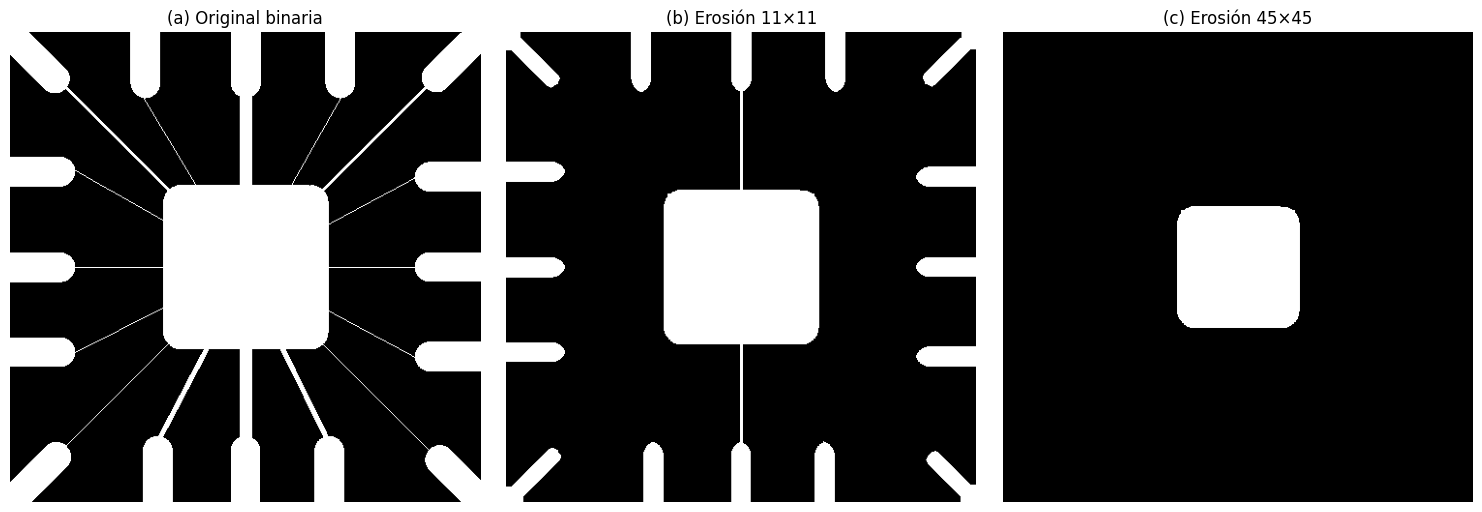

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Carga ---
# Pon aquí la ruta a TU imagen original (la binaria 486x486 que aparece arriba-izquierda)
img_path = "wirebond_mask.tiff"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# --- 2) A binario (por si no viene ya perfecto) ---
# Queremos fondo negro (0) y objeto blanco (255) para erosionar el blanco.
# Si te queda al revés, activa 'invert=True' abajo.
_, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Si tu objeto está en negro sobre blanco, invierte:
invert = False  # cámbialo a True si ves que se erosiona el fondo en vez del objeto
if invert:
    bw = cv2.bitwise_not(bw)

# --- 3) Erosiones con SE cuadrados ---
sizes = [11, 45]
eroded = []
for k in sizes:
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))  # cuadrado kxk
    e = cv2.erode(bw, se, iterations=1)                     # erosión
    eroded.append((k, e))

# --- 4) Mostrar como en la figura ---
titles = ["(a) Original binaria",
          "(b) Erosión 11×11",
          "(c) Erosión 45×45"]

imgs_to_show = [bw] + [e for _, e in eroded]

plt.figure(figsize=(20, 5))
for i, (title, im) in enumerate(zip(titles, imgs_to_show), start=1):
    plt.subplot(1, 4, i)
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


True

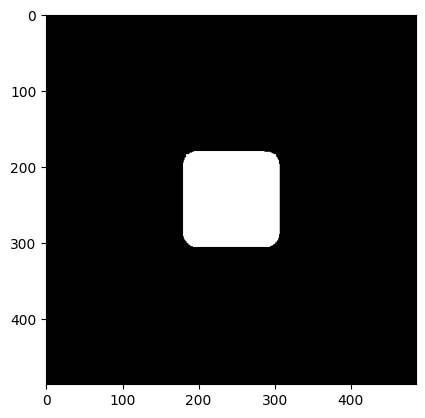

In [22]:
eroded3 = imgs_to_show[3]
plt.imshow(eroded3, cmap='gray', vmin=0, vmax=255)
cv2.imwrite("wirebond_eroded_45x45.png", eroded3)

### Dilatación

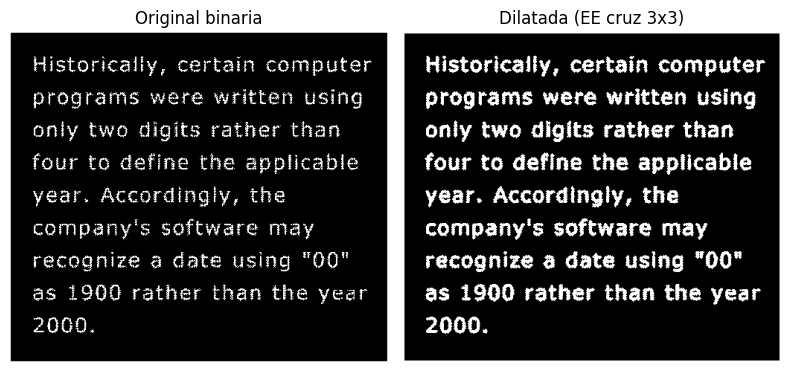

In [7]:
# 1. Cargar imagen en escala de grises
img = cv2.imread("text_gaps.tiff", cv2.IMREAD_GRAYSCALE)

# 2. Binarizar (por si la imagen no es estrictamente binaria)
_, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3. Definir elemento estructurante 3x3 con ceros en las esquinas
#    Es decir, en forma de cruz
se = np.array([[0,1,0],
               [1,1,1],
               [0,1,0]], dtype=np.uint8)

# 4. Aplicar dilatación
dilated = cv2.dilate(bw, se, iterations=1)
# 5. Mostrar resultados con subplot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(bw, cmap='gray')
plt.title("Original binaria")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(dilated, cmap='gray')
plt.title("Dilatada (EE cruz 3x3)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Aplicación sucesiva de apertura y cierre como filtor morfológico

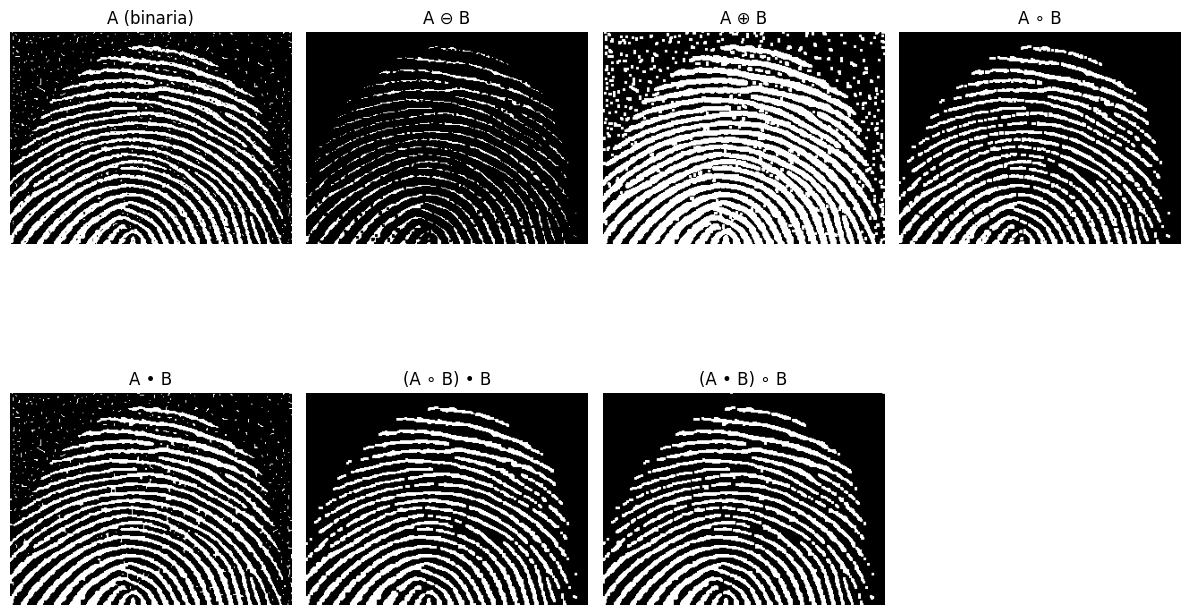

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Cargar y binarizar (Otsu). Si los surcos salen negros, invierte=True.
img = cv2.imread("noisy_fingerprint.tif", cv2.IMREAD_GRAYSCALE)
_, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

invert = False   # pon True si ves que el objeto de interés queda negro
if invert:
    bw = cv2.bitwise_not(bw)

# 2) Elemento estructurante 3x3 todo 1's (rectángulo)
B = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# 3) Operaciones básicas
eroded   = cv2.erode(bw, B, iterations=1)       # A ⊖ B
dilated  = cv2.dilate(bw, B, iterations=1)      # A ⊕ B

# 4) Compuestas
opened   = cv2.morphologyEx(bw, cv2.MORPH_OPEN,  B)   # (A ⊖ B) ⊕ B = A ∘ B
closed   = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, B)   # (A ⊕ B) ⊖ B = A • B

# 5) Encadenadas (como en la figura)
open_then_close  = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, B)  # (A ∘ B) • B
close_then_open  = cv2.morphologyEx(closed, cv2.MORPH_OPEN,  B)  # (A • B) ∘ B

# 6) Mostrar
titles = ["A (binaria)", "A ⊖ B", "A ⊕ B", "A ∘ B", "A • B", "(A ∘ B) • B", "(A • B) ∘ B"]
images = [bw, eroded, dilated, opened, closed, open_then_close, close_then_open]

plt.figure(figsize=(12, 8))
for i,(t,im) in enumerate(zip(titles, images), 1):
    plt.subplot(2,4,i)  # 2 filas, 4 cols (queda 1 hueco)
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    plt.title(t); plt.axis('off')

plt.tight_layout(); plt.show()


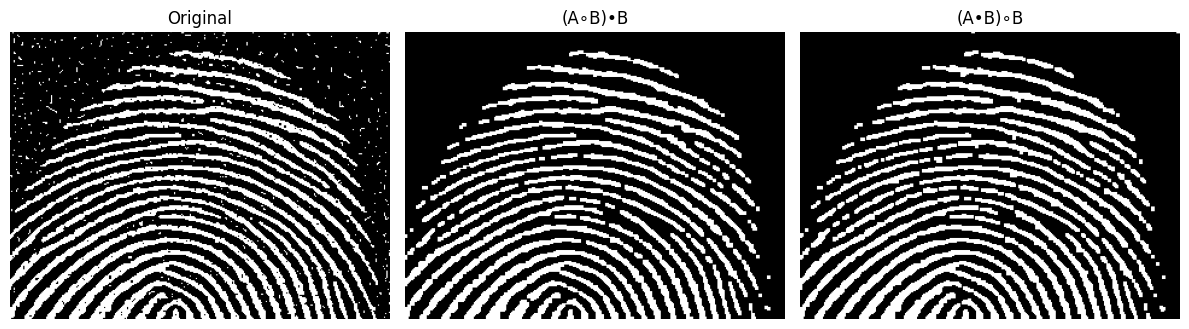

In [9]:
# 5. Mostrar en un subplot 1x3
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(bw, cmap='gray')
plt.title("Original"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(open_then_close, cmap='gray')
plt.title("(A∘B)•B"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(close_then_open, cmap='gray')
plt.title("(A•B)∘B"); plt.axis("off")

plt.tight_layout()
plt.show()

### Transforamda Hit or miss

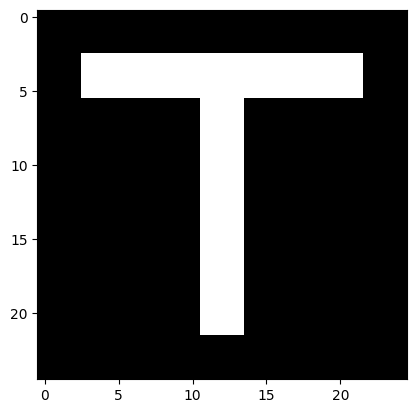

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Cargar y binarizar (texto/blanco=1, fondo=0) ---
img = cv2.imread("UTK.tiff", cv2.IMREAD_GRAYSCALE)  # o tu imagen
_, bw255 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
bw01 = (bw255 > 0).astype(np.uint8)

# --- Kernel T de 35x35 (ajusta bar_th y stem_th si tu trazo es distinto) ---
def make_T_kernel(box=35, margin=3, bar_th=5, stem_th=5):
    k = np.full((box, box), 0, np.int8)  # -1 = don't care
    H, W = k.shape
    cx = W//2

    # T "hacia arriba": barra y mástil
    # barra horizontal
    k[margin:margin+bar_th, margin:W-margin] = 1
    # mástil vertical
    x0 = cx - stem_th//2
    k[margin:H-margin, x0:x0+stem_th] = 1

    # zona de fondo obligatorio alrededor (cinturón fino)
    # una fila de 0 justo encima de la barra
    k[margin-1, margin:W-margin] = 0
    # columnas 0 a los lados del mástil
    #k[margin:H-margin, x0-1] = 0
    #k[margin:H-margin, x0+stem_th] = 0
    # 0 justo debajo del final del mástil
    k[H-margin, x0:x0+stem_th] = 0

    return k

K_up = make_T_kernel(box=25, margin=3, bar_th=3, stem_th=3)
plt.imshow(K_up, cmap='gray')

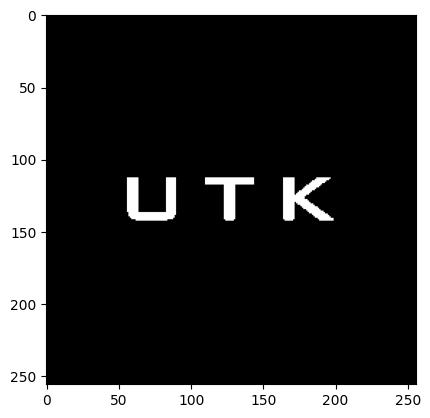

In [88]:
plt.imshow(bw01, cmap='gray')

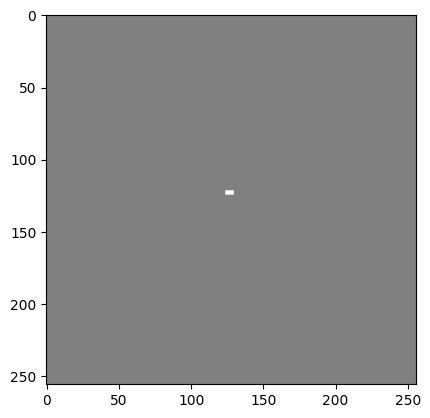

In [84]:

hits = cv2.morphologyEx(bw01, cv2.MORPH_HITMISS, K_up)

# convertir a 0/255 para ver/usar
hit255 = (hits*255).astype(np.uint8)
plt.imshow(hit255, cmap='gray', vmin=-1, vmax=1)


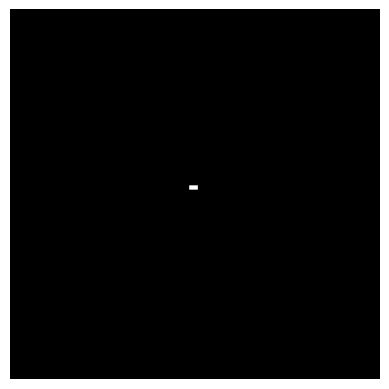

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# bw01: imagen binaria 0/1
# K_up: kernel int8 con valores {-1,0,1} (para hit-or-miss)

# 1) Kernel para EROSIÓN: solo los +1 de K_up
K_hit = (K_up == 1).astype(np.uint8)        # 1 donde hay estructura, 0 resto

# 2) Aconsejable trabajar en 0/255 con OpenCV
bw255 = (bw01 * 255).astype(np.uint8)

# 3) Erosión
eSingle = cv2.erode(bw255, K_hit, iterations=1)

# 4) Mostrar
plt.imshow(eSingle, cmap='gray', vmin=0, vmax=255)
plt.axis('off'); plt.show()



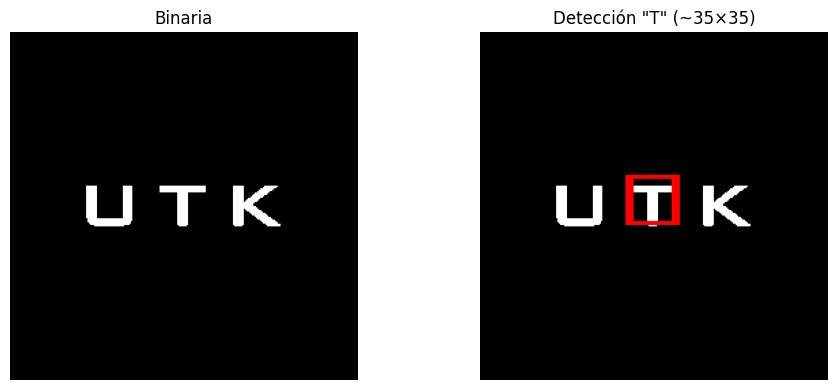

In [89]:

# --- (Opcional) marcar los centros detectados con un recuadro 35x35 ---
overlay = cv2.cvtColor(bw255, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(hits==1)
box = 35
for y, x in zip(ys, xs):
    cv2.rectangle(overlay, (x-box//2, y-box//2), (x+box//2, y+box//2), (0,0,255), 1)

# --- Mostrar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(bw255, cmap='gray'); plt.title("Binaria"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(overlay[..., ::-1]); plt.title('Detección "T" (~35×35)'); plt.axis('off')
plt.tight_layout(); plt.show()

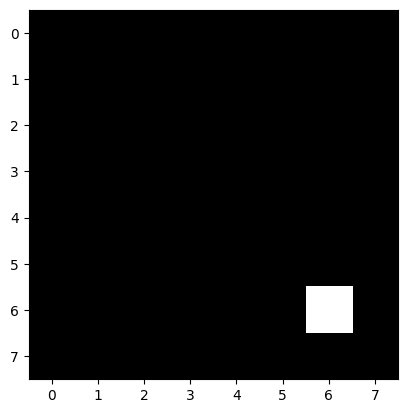

In [93]:
import cv2
import numpy as np

# Create the input image
input_image = np.array((
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 255, 0, 0, 0, 255],
    [0, 0, 255, 255, 0, 0, 0, 0],
    [0, 0, 255, 255, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 0, 0, 255, 255, 255],
    [0,255, 0, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 0, 255, 0]), dtype="uint8")

# Construct the structuring element
kernel = np.array((
        [1, 1, 1],
        [0, 1, -1],
        [0, 1, -1]), dtype="int")

# Apply hit-or-miss transformation
output_image = cv2.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel)
plt.imshow(output_image, cmap='gray')


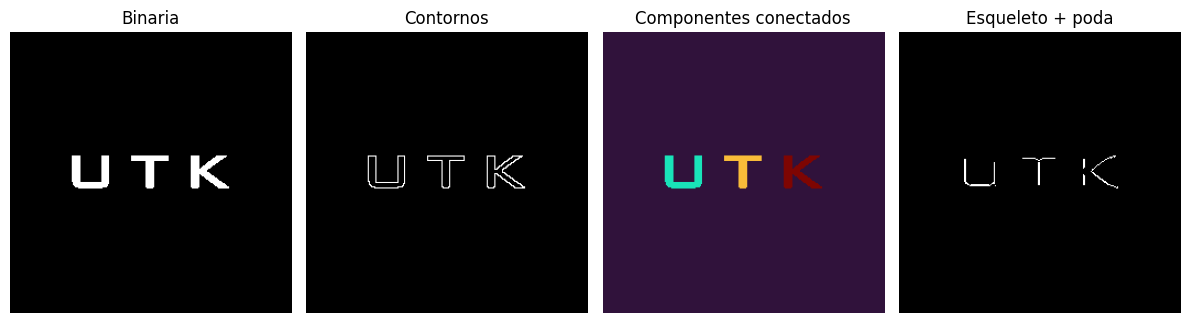

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Cargar y binarizar (texto blanco sobre negro) ---
img = cv2.imread("UTK.tiff", cv2.IMREAD_GRAYSCALE)
_, bw = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Si el texto queda negro (fondo blanco), invierte:
if np.mean(bw) > 127:  # fondo claro => invertimos
    bw = 255 - bw

# --- 1) Extracción de contornos (borde externo) ---
#   método clásico: contorno = A - erode(A)
se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
contour = cv2.subtract(bw, cv2.erode(bw, se3, iterations=1))

# --- 2) Componentes conectados (etiquetado de letras) ---
num, labels, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity=8)
# colorizar etiquetas para visualización
label_norm = (255*(labels/(num-1+1e-9))).astype(np.uint8)
cc_color = cv2.applyColorMap(label_norm, cv2.COLORMAP_TURBO)

# --- 3) Esqueleto (método morfológico por erosión-apertura) ---
def morphological_skeleton(bin255):
    skel = np.zeros_like(bin255)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    img = bin255.copy()
    while True:
        eroded = cv2.erode(img, element)
        opened = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

skeleton = morphological_skeleton(bw)

# --- 3b) Poda (eliminar espolones cortos del esqueleto) ---
# Kernels de extremos (hit-or-miss). Eliminan endpoints repetidamente.
end_kernels = [
    np.array([[0,0,0],
              [0,1,0],
              [0,1,0]], np.uint8),
    np.array([[0,0,0],
              [0,1,0],
              [0,0,1]], np.uint8),
    np.array([[0,0,0],
              [0,1,0],
              [1,0,0]], np.uint8),
    np.array([[0,1,0],
              [0,1,0],
              [0,0,0]], np.uint8),
    np.array([[0,1,0],
              [0,1,0],
              [0,0,1]], np.uint8),
    np.array([[0,1,0],
              [0,1,0],
              [1,0,0]], np.uint8),
    np.array([[0,0,1],
              [0,1,0],
              [0,0,0]], np.uint8),
    np.array([[1,0,0],
              [0,1,0],
              [0,0,0]], np.uint8),
]

def prune_skeleton(skel255, iterations=10):
    sk = (skel255 > 0).astype(np.uint8)
    for _ in range(iterations):
        hit = np.zeros_like(sk)
        for k in end_kernels:
            # hit-or-miss sin -1: erosión del objeto con k y del fondo con k_reflejado_en_0
            e1 = cv2.erode(sk, k)
            e2 = cv2.erode(1-sk, 1-k)  # 1 en posiciones donde queremos fondo
            hit = np.bitwise_or(hit, np.bitwise_and(e1, e2))
        # quitar endpoints detectados
        sk = cv2.bitwise_and(sk, 1-hit)
    return (sk*255).astype(np.uint8)

skeleton_pruned = prune_skeleton(skeleton, iterations=6)

# --- Mostrar resultados: Original, Contorno, CC, Esqueleto podado ---
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(bw, cmap='gray'); plt.title("Binaria"); plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(contour, cmap='gray'); plt.title("Contornos"); plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(cc_color[..., ::-1]); plt.title("Componentes conectados"); plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(skeleton_pruned, cmap='gray'); plt.title("Esqueleto + poda"); plt.axis('off')

plt.tight_layout(); plt.show()


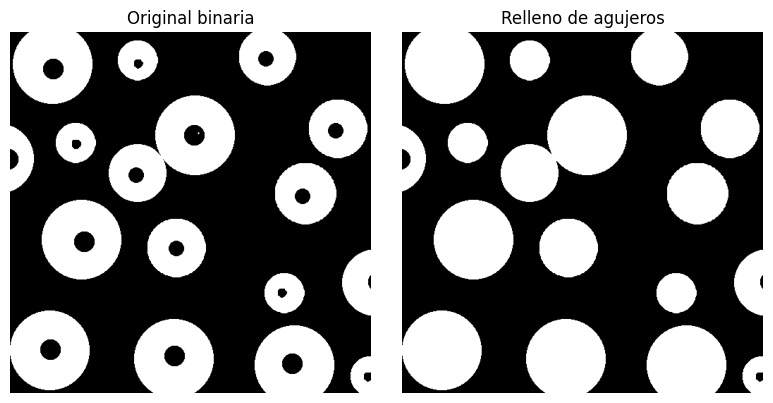

In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fill_holes_robust(bw255):
    # 1) Asegurar binaria 0/255
    bw = (bw255 > 0).astype(np.uint8) * 255

    # 2) Forzar objeto blanco / fondo negro (si hay fondo claro, invertimos)
    invert_back = False
    if np.mean(bw) > 127:      # fondo mayormente claro
        bw = 255 - bw
        invert_back = True

    # 3) Añadir borde negro para que (0,0) sea fondo seguro
    bordered = cv2.copyMakeBorder(bw, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    # 4) Flood fill desde la esquina: “pintamos” TODO el fondo conectado a borde
    mask = np.zeros((bordered.shape[0] + 2, bordered.shape[1] + 2), np.uint8)
    ff = bordered.copy()
    cv2.floodFill(ff, mask, seedPoint=(0, 0), newVal=255)

    # 5) Quitar borde, invertir (fondo→0, huecos→255) y rellenar
    ff = ff[1:-1, 1:-1]
    holes = cv2.bitwise_not(ff)          # 255 solo en huecos internos
    filled = cv2.bitwise_or(bw, holes)   # original + huecos

    # 6) Volver a la polaridad original si hubo inversión
    if invert_back:
        filled = 255 - filled

    return filled

# --- Ejemplo de uso con tu imagen ---
img = cv2.imread("filling.tiff", cv2.IMREAD_GRAYSCALE)
_, bw_gaps = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

filled = fill_holes_robust(bw_gaps)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(bw_gaps, cmap='gray'); plt.title("Original binaria"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(filled,  cmap='gray'); plt.title("Relleno de agujeros"); plt.axis('off')
plt.tight_layout(); plt.show()
